## Bootstrap自助法

#####  导入安装包

In [1]:
import random
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from random import choices

import statsmodels.api as sm
from statsmodels.api import OLS
import seaborn as sns ## 数据可视化库，主要用于绘制统计图表
from functools import partial ## 用于创建偏函数。偏函数可以固定某些参数，简化函数调用。
from ISLP import load_data
from ISLP.models import sklearn_sm ## 函数用于将statsmodels模型与sklearn的交叉验证工具兼容。
from ISLP.models import (ModelSpec as MS, ## ModelSpec（MS）是一个类，用于定义模型规范，特别是在处理多项式回归等复杂模型时。
                         summarize, ## summarize函数用于总结模型的结果，例如回归模型的系数、标准误差等。
                         poly) ## poly函数用于创建多项式特征。

In [3]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import BaggingClassifier,BaggingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score ## 用于计算分类模型的准确率（分类正确的样本数占总样本数的比例），是最直观的性能评估指标之一
from sklearn.datasets import load_iris
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.base import clone ## 函数用于复制模型。它可以创建模型的一个副本，确保每次交叉验证都是独立的。
from sklearn.model_selection import  (cross_validate, ## 执行交叉验证,可以对模型进行多次训练和验证，返回模型的性能指标。
                                      KFold, ## 创建k折交叉验证器。
                                      ShuffleSplit) ## 创建随机打乱的交叉验证器。
from sklearn import metrics

In [43]:
import warnings
warnings.simplefilter("ignore", category=UserWarning)
warnings.filterwarnings('ignore')

In [7]:
%matplotlib inline
# 设置字体为支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

### 1. Bootstrap基础概念
   


Bootstrap是一种通过重采样评估统计量分布的统计方法，无需对数据分布做假设。   
其核心是通过从原始数据中有放回地抽样生成新数据集，用于估计模型的不确定性；广泛应用于模型验证、参数估计和预测误差评估。

为什么需要Bootstrap？

传统统计方法通常依赖于严格的假设（如正态分布），而Bootstrap不需要这些假设，充分利用了给定的观测信息，不需要模型其他的假设和增加新的观测，并且具有稳健性和效率高的特点；且可以应用于复杂的模型和非线性统计量，提供灵活且强大的工具。

•优点：无需假设分布、适用于小数据集。

•缺点：计算成本高、引入估计偏差。

------
自助法步骤：

1.抽取Bootstrap样本：从原始样本（容量为n）中有放回抽取n个观测值，生成一个新样本。

2.计算统计量：在新样本上计算目标统计量（如均值、中位数、回归系数等）。

3.重复过程：重复上述步骤B次（通常B=1000），得到B个统计量的估计值。

4.构建分布：基于B个估计值形成经验分布，用于进一步分析。 

示例：我们希望在一个简单模型下确定最佳投资分配方案。使 $Var(\alpha X+(1-\alpha)Y)$ 最小化。

$$\alpha=\frac{\sigma^2_Y-\sigma_XY}{\sigma^2_X+\sigma^2_Y-2\sigma_XY}\tag{5.8}$$
其中 $\sigma^2_X=Var(X),\sigma^2_Y=Var(Y),\sigma_{XY}=Cov(X,Y)$
$$\alpha=\frac{\hat\sigma^2_Y-\hat\sigma_{XY}}{\hat\sigma^2_X+\hat\sigma^2_Y-2\hat\sigma_{XY}}\tag{5.9}$$

![figure5.11.png](figure5.11.png)

$\sigma^2_X=1,\sigma^2_Y=1.25,\sigma_{XY}=0.5$

In [97]:
a_list = []
for _ in range(1000):
    X = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1.25]], 100)##模拟生成数据，α=0.6
    a=(np.var(X[:, 1])-np.cov(X[:, 0],X[:, 1]))/(np.var(X[:, 0])+np.var(X[:, 1])-2*np.cov(X[:, 0],X[:, 1]))
    a = a[:, 1][0]    
    a_list.append(a)
a_mean = np.mean(a_list)
a_mean

0.6047761352316836

In [99]:
a_deviation = np.std(a_list, ddof = 1)##无偏
a_deviation

0.0833165082555754

对于 $\alpha $的全部 1000 次估计的均值为：
$$\overline{\alpha }=\frac{1}{1,000}\sum_{r=1}^{1,000} \hat\alpha _r=0.6048\tag{5.10}$$
非常接近$\alpha  = 0.6$，并且这些估计值的标准差为：
$$ \sqrt {\frac{1}{1000 - 1}\sum_{r = 1}^{1000} (\hat\alpha _r-\overline{\alpha })^2}=0.0833\tag{5.11}$$
对于$\alpha $ 的全部 1000 次估计的均值为：
这让我们很好地了解了  $\hat\alpha $ 的准确度：$\hat\alpha:SE(\hat\alpha)\approx0.0833$ 。
严格来说，对于从总体中抽取的随机样本，平均而言，我们预计 $\hat\alpha $与 $\alpha $  的差值大约为 0.08 。

In [120]:

ab_list = []
X = np.random.multivariate_normal([0, 0], [[1, 0.5], [0.5, 1.25]], 100)
for _ in range(1000):
    x = choices(X[:, 0], k=100)##有放回抽样
    y = choices(X[:, 1], k=100)
    ab = (np.var(y)-np.cov(x,y))/(np.var(x)+np.var(y)-2*np.cov(x,y))
    ab = ab[:, 1][0]    
    ab_list.append(ab)
ab_mean = np.mean(ab_list)
ab_mean

0.5905702866315549

In [122]:
ab_deviation = np.std(ab_list, ddof = 1)##设置成无偏的
ab_deviation

0.05499105375879299

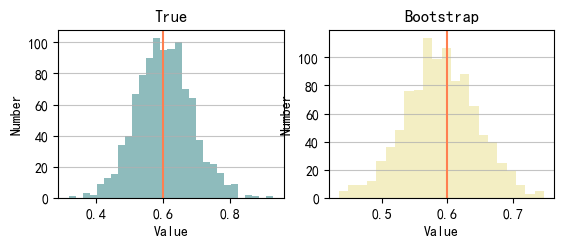

In [124]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
n, bins, patches =plt.hist(x=a_list, bins='auto', color='cadetblue',alpha=0.7, rwidth=10)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Number')
plt.title('True')
plt.axvline(0.6,c="coral")

ax2 = fig.add_subplot(2,2,2)
n, bins, patches =plt.hist(x=ab_list, bins='auto', color='palegoldenrod',alpha=0.7, rwidth=10)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Number')
plt.title('Bootstrap')
plt.axvline(0.6,c="coral")
plt.show()

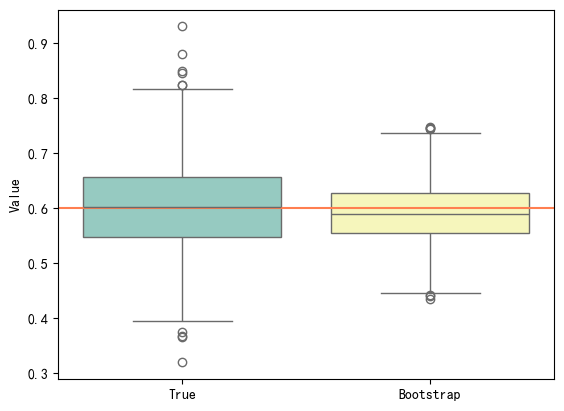

In [126]:
data =pd.DataFrame ({'True':a_list,'Bootstrap':ab_list})
sns.boxplot(data=data.iloc[:,0:2],palette="Set3")
plt.axhline(0.6,c="coral")
plt.ylabel('Value')
plt.show()

表明自助法是一种有效的统计方法，可以用来估计和验证统计量的分布，并且结果与理论值一致。

### 2. bootstrap 和 交叉验证

---------
交叉验证和自助法的同异：

相同点：两者都是重采样的方法，都是在数据集较小的时候常用的方法。

不同点：

1. 两者的重采样方法不同。在K折交叉验证中，把原始数据集分成k等分（各等分之间没交集），每一次验证中，把其中一份作为验证集，剩余的作为测试集；在自助法中，并不区分测试集和验证集，并且在重采样过程中，是允许替代的，即同一个样本可以重复出现。

自助法模型选择阶段和最终模型训练阶段的训练集规模相同，而交叉验证法模型选择阶段和最终模型训练阶段的训练集规模不同。Bootstrap通过重复抽样，避免了Cross Validation造成的样本减少的问题。自助法训练集数据分布可能与原始数据集数据分布不同，而交叉验证法保持数据分布的一致性。


2. 两者的适用性不同。交叉验证主要应用于模型的选择，例如KNN算法中选多大的K，才能尽可能减小模型的真实误差。而自助法主要用来测算选定的模型中的不确定性，例如参数的标准差多大。


In [35]:
Auto = load_data('Auto')

In [45]:
# 用于存储不同阶数模型的自助法均方误差
boot_mse = np.zeros(5)

# 提取数据特征和目标变量
H = np.array(Auto['horsepower'])
Y = Auto['mpg']

# 自助法抽样次数
n_bootstrap = 1000

for i, d in enumerate(range(1, 6)):
    mse_scores_bootstrap = []
    # 构建多项式特征矩阵
    X = np.power.outer(H, np.arange(d + 1))
    for _ in range(n_bootstrap):
        # 有放回抽样生成自助样本集
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_boot = X[indices]
        y_boot = Y[indices]

        # 拟合线性回归模型
        model = OLS(y_boot, X_boot).fit()
        y_pred = model.predict(X)

        # 计算均方误差
        mse = mean_squared_error(Y, y_pred)
        mse_scores_bootstrap.append(mse)

    # 计算自助法均方误差的均值
    boot_mse[i] = np.mean(mse_scores_bootstrap)

print("不同阶数模型的自助法均方误差:", boot_mse)

不同阶数模型的自助法均方误差: [24.08429953 19.11983763 19.13042144 19.14664694 18.74272443]


In [47]:
X = Auto.drop(columns='mpg')
Y = Auto['mpg']

lambdas = np.linspace(0.001, 10, 10) / Y.std()

# 用于存储不同alpha值的自助法均方误差
boot_mse = np.zeros(10)

# 自助法抽样次数
n_bootstrap = 1000

for j, alpha in enumerate(lambdas):
    mse_scores_bootstrap = []
    for _ in range(n_bootstrap):
        # 有放回抽样生成自助样本集
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_boot = X.iloc[indices]
        Y_boot = Y.iloc[indices]

        # 拟合岭回归模型
        model = Ridge(alpha=alpha)
        model.fit(X_boot, Y_boot)

        # 对原始数据进行预测
        y_pred = model.predict(X)

        # 计算均方误差
        mse = mean_squared_error(Y, y_pred)
        mse_scores_bootstrap.append(mse)

    # 计算自助法均方误差的均值
    boot_mse[j] = np.mean(mse_scores_bootstrap)

print("不同lambdas值的自助法均方误差:", boot_mse)

不同lambdas值的自助法均方误差: [11.10217012 11.10556673 11.09932515 11.10178664 11.10558787 11.10264881
 11.10149341 11.09955031 11.10093099 11.0972584 ]


In [48]:
X = Auto.drop(columns='mpg')
Y = Auto['mpg']

lambdas = np.linspace(0.001, 10, 10) / Y.std()

# 自助法抽样次数
n_bootstrap = 1000
# k折交叉验证的折数
k = 10

# 用于存储不同lambdas值的结合方法均方误差
combined_mse = np.zeros(10)

for j, alpha in enumerate(lambdas):
    mse_scores_combined = []
    for _ in range(n_bootstrap):
        # 有放回抽样生成自助样本集
        indices = np.random.choice(len(X), size=len(X), replace=True)
        X_boot = X.iloc[indices]
        Y_boot = Y.iloc[indices]

        kf = KFold(n_splits=k)
        mse_scores_cv = []
        for train_index, test_index in kf.split(X_boot):
            X_train, X_test = X_boot.iloc[train_index], X_boot.iloc[test_index]
            Y_train, Y_test = Y_boot.iloc[train_index], Y_boot.iloc[test_index]

            model = Ridge(alpha=alpha)
            model.fit(X_train, Y_train)
            y_pred = model.predict(X_test)
            mse = mean_squared_error(Y_test, y_pred)
            mse_scores_cv.append(mse)

        # 计算当前自助样本集上k折交叉验证的平均均方误差
        mse_boot_cv = np.mean(mse_scores_cv)
        mse_scores_combined.append(mse_boot_cv)

    # 计算所有自助样本集上交叉验证均方误差的平均值
    combined_mse[j] = np.mean(mse_scores_combined)

print("不同alpha值的结合方法均方误差:", combined_mse)

不同alpha值的结合方法均方误差: [11.16012429 11.0791369  11.08818716 11.14135936 11.22238582 11.10152773
 11.16479231 11.10637377 11.12336466 11.19148875]


In [49]:
lambdas = np.linspace(0.001, 10,10)/ Y.std()
lambdas

array([1.28122875e-04, 1.42472637e-01, 2.84817152e-01, 4.27161666e-01,
       5.69506180e-01, 7.11850695e-01, 8.54195209e-01, 9.96539723e-01,
       1.13888424e+00, 1.28122875e+00])

————————
##### 应用1：估计统计量的分布，计算置信区间

In [52]:
def boot_SE(func,D,n=None,B=1000,seed=0):
    rng = np.random.default_rng(seed)
    first_, second_ = 0, 0
    values = []
    n = n or D.shape[0]
    for _ in range(B):
        idx = rng.choice(D.index,n,replace=True)
        value = func(D, idx)
        values.append(value)
        first_ += value
        second_ += value**2
    values = np.array(values)
    mean = np.mean(values, axis=0)
    return mean,np.sqrt(second_ / B - (first_ / B)**2), np.percentile(values, [2.5, 97.5], axis=0)

In [53]:
def boot_OLS(model_matrix, response, D, idx):
    D_ = D.loc[idx]
    Y_ = D_[response]
    X_ = clone(model_matrix).fit_transform(D_)
    return sm.OLS(Y_, X_).fit().params

In [54]:
hp_func = partial(boot_OLS, MS(['horsepower']), 'mpg')
## 部分参数固定，创建了一个新的可调用对象
## partial函数将boot_OLS函数的model_matrix参数固定为MS(['horsepower'])，response参数固定为'mpg' 

In [55]:
Auto = Auto.reset_index(drop=True) 
Auto.index

RangeIndex(start=0, stop=392, step=1)

In [56]:
# 线性模型
hp_func = partial(boot_OLS, MS(['horsepower']), 'mpg')
mean, se, ci = boot_SE(hp_func, Auto, B=1000, seed=10)
print("Bootstrap Linear Model:")
print("Mean:", mean)
print("Standard Error:", se)
print("95% Confidence Interval:\n", ci)


Bootstrap Linear Model:
Mean: [39.99071897 -0.15835748]
Standard Error: intercept     0.848807
horsepower    0.007352
dtype: float64
95% Confidence Interval:
 [[38.32508087 -0.17326841]
 [41.65702675 -0.14410481]]


In [57]:
# OLS 线性模型
X = sm.add_constant(Auto[['horsepower']])
model = sm.OLS(Auto['mpg'], X).fit()
print("\nOLS Linear Model:")
print("Summary:\n", model.summary())


OLS Linear Model:
Summary:
                             OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           7.03e-81
Time:                        16:43:53   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359  

In [58]:
# 二次模型
quad_model = MS([poly('horsepower', 2, raw=True)])
quad_func = partial(boot_OLS, quad_model, 'mpg')
mean_quad, se_quad, ci_quad = boot_SE(quad_func, Auto, B=1000, seed=10)
print("\nBootstrap Quadratic Model:")
print("Mean:", mean_quad)
print("Standard Error:", se_quad)
print("95% Confidence Interval:\n", ci_quad)


Bootstrap Quadratic Model:
Mean: [ 5.70293995e+01 -4.68264311e-01  1.23848008e-03]
Standard Error: intercept                                  2.149153
poly(horsepower, degree=2, raw=True)[0]    0.034437
poly(horsepower, degree=2, raw=True)[1]    0.000125
dtype: float64
95% Confidence Interval:
 [[ 5.29380300e+01 -5.34128507e-01  9.97681066e-04]
 [ 6.11818082e+01 -4.02223090e-01  1.47896191e-03]]


In [59]:
# OLS 二次模型
X_quad = quad_model.fit_transform(Auto[['horsepower']])
model_quad = sm.OLS(Auto['mpg'], X_quad).fit()
print("\nOLS Quadratic Model:")
print("Summary:\n", model_quad.summary())


OLS Quadratic Model:
Summary:
                             OLS Regression Results                            
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Fri, 11 Apr 2025   Prob (F-statistic):           5.40e-99
Time:                        16:44:03   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

### 3. bootstrap类型
标准Bootstrap 和.632估计器

.632 估计是对普通自助法的一种改进。
$$\Pr\{\text{观测} \ i \in \text{自助法样本} \ b\} = 1 - \left(1 - \frac{1}{N}\right)^N \tag{7.55}\approx 1 - e^{-1}= 0.632$$
在普通自助法中，每个自助样本集大约包含原始数据集63.2%的不同样本。.632 估计利用了这一特性，通过对自助样本集和原始数据集上的模型性能进行加权平均，来得到更准确的模型性能估计。具体来说，它将自助样本集上的模型性能估计值与原始数据集上的模型性能估计值按照一定的权重进行组合，权重的选择基于自助样本集包含原始数据的比例。

计算公式：设M为模型，D为原始数据集，$D_i$为第i个自助样本集，n为自助样本集的数量。$err_{in}(M)$表示模型M在原始数据集D上的误差，$err_{out}(M, D_i)$表示模型M在自助样本集$D_i$上的泛化误差（通过对未被抽到的样本进行预测得到）。则.632 估计的误差估计值$err_{.632}(M)$为：$$err_{.632}(M) = 0.368err_{in}(M)+ 0.632\frac{1}{n}\sum_{i = 1}^{n}err_{out}(M, D_i)$$

相比普通自助法，.632 估计能够更好地平衡模型在原始数据集和自助样本集上的性能，减少了对模型性能的高估或低估，通常能提供更准确的模型性能估计。

##### 应用2：模型评估：计算预测模型的平均准确率

In [60]:
# 加载鸢尾花数据集
iris = load_iris()
X = iris.data
y = iris.target

In [131]:
iris 

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [61]:
# 普通自助法
n_bootstrap = 1000
acc_scores_bootstrap = []
for _ in range(n_bootstrap):
    X_boot, y_boot = resample(X, y)
    model = LogisticRegression()
    model.fit(X_boot, y_boot)
    y_pred = model.predict(X)
    acc = accuracy_score(y, y_pred)
    acc_scores_bootstrap.append(acc)

mean_acc_bootstrap = np.mean(acc_scores_bootstrap)
print("普通自助法的平均准确率:", mean_acc_bootstrap)

普通自助法的平均准确率: 0.9715133333333333


In [62]:
#.632估计器
n_bootstrap = 1000
in_bag_accs = []
out_bag_accs = []
for _ in range(n_bootstrap):
    indices = np.random.choice(len(X), size=len(X), replace=True)
    X_boot = X[indices]
    y_boot = y[indices]
    model = LogisticRegression()
    model.fit(X_boot, y_boot)

    # 计算袋内准确率（在自助样本集上的准确率）
    y_pred_in_bag = model.predict(X_boot)
    in_bag_acc = accuracy_score(y_boot, y_pred_in_bag)
    in_bag_accs.append(in_bag_acc)

    # 计算袋外准确率（在未被抽到的样本上的准确率）
    out_indices = np.setdiff1d(np.arange(len(X)), indices)
    X_out = X[out_indices]
    y_out = y[out_indices]
    y_pred_out = model.predict(X_out)
    out_bag_acc = accuracy_score(y_out, y_pred_out) if len(y_out) > 0 else 0
    out_bag_accs.append(out_bag_acc)

# 计算.632估计的准确率
mean_in_bag_acc = np.mean(in_bag_accs)
mean_out_bag_acc = np.mean(out_bag_accs)
acc_632 = 0.368 * mean_in_bag_acc + 0.632 * mean_out_bag_acc
print(".632估计器的准确率:", acc_632)

.632估计器的准确率: 0.9682301356829133


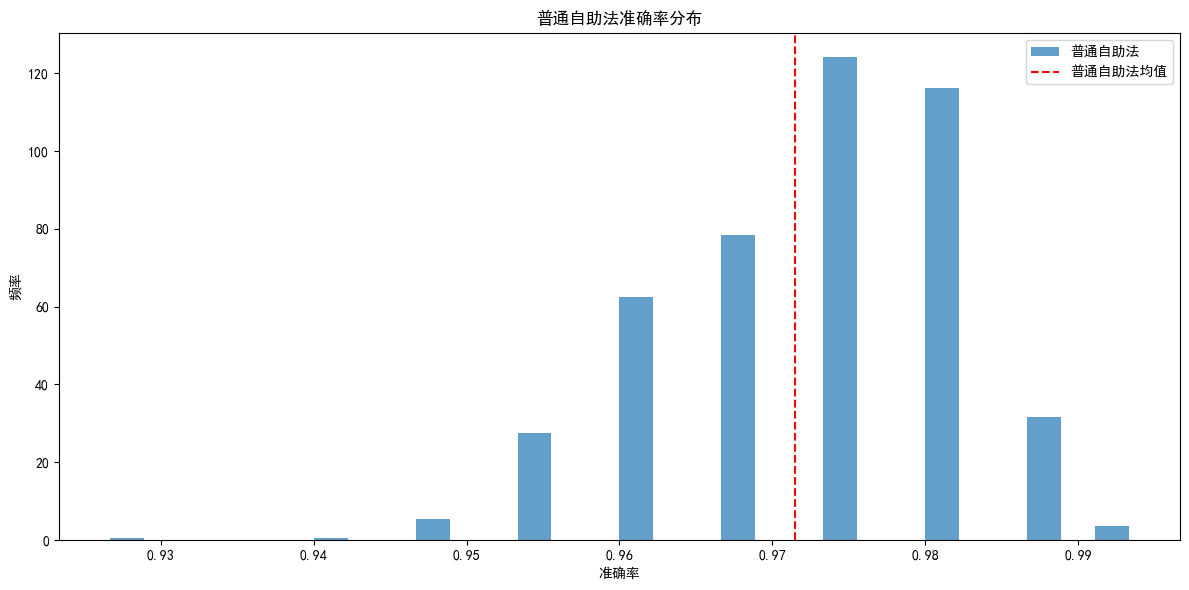

In [63]:
# 绘制直方图对比准确率分布
plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
plt.hist(acc_scores_bootstrap, bins=30, density=True, alpha=0.7, label='普通自助法')
plt.axvline(x=mean_acc_bootstrap, color='r', linestyle='--', label='普通自助法均值')
plt.xlabel('准确率')
plt.ylabel('频率')
plt.title('普通自助法准确率分布')
plt.legend()

# plt.subplot(1, 2, 2)
# # 这里假设我们用 acc_632 来模拟.632 估计器的分布（实际是一个值，为了对比绘制）
# plt.hist([acc_632] * n_bootstrap, bins=30, density=True, alpha=0.7, label='.632估计器')
# plt.axvline(x=acc_632, color='r', linestyle='--', label='.632估计器值')
# plt.xlabel('准确率')
# plt.ylabel('频率')
# plt.title('.632估计器准确率分布')
# plt.legend()

plt.tight_layout()
plt.show()

###  4.Bagging

自助法在集成学习中应用
Bagging 全称叫 Bootstrap aggregating。每个基学习器都会对训练集进行有放回抽样得到子训练集。每个基学习器基于不同子训练集进行训练，并综合所有基学习器的预测值得到最终的预测结果。Bagging 常用的综合方法是投票法，票数最多的类别为预测类别。

![figurejicheng.jpg](figurejicheng.jpg)

##### 应用3：减少过拟合，使用 Bagging 集成学习（基于自助法）

In [140]:
iris = load_iris()
X, y = iris.data, iris.target 

##### 决策树 
![figure.tree.png](figure.tree.png)

In [164]:
# 简单决策树
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=0)

single_tree_clf = DecisionTreeClassifier(random_state=0)
single_tree_clf.fit(X_train,y_train)
print('single_tree train_accuracy: %s'%(single_tree_clf.score(X_train,y_train)))

y_test_pred = single_tree_clf.predict(X_test)
print('single_tree test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred)))

single_tree train_accuracy: 1.0
single_tree test_accuracy: 0.9469026548672567


In [166]:
# Bagging
# OOB_score
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.75, random_state=0)

bagging_clf_OOB = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=100,random_state=0,
                               bootstrap=True, oob_score=True,n_jobs=-1)
bagging_clf_OOB.fit(X,y)
print('Bagging oob_score: %s'%(bagging_clf_OOB.oob_score_))

# test_score
bagging_clf_test = BaggingClassifier(DecisionTreeClassifier(),
                               n_estimators=100,random_state=0,
                               bootstrap=True, oob_score=False,n_jobs=-1)
bagging_clf_test.fit(X_train,y_train)
y_test_pred = bagging_clf_test.predict(X_test)
print('Bagging test_accuracy: %s'%(metrics.accuracy_score(y_test,y_test_pred)))

Bagging oob_score: 0.9533333333333334
Bagging test_accuracy: 0.9557522123893806


In [148]:
# 默认的变量特征重要性是在所有树的节点划分中，每个变量划分带来的基尼系数增益，
# 并除总增益值使所有变量特征重要性和为1
feature_importances = np.mean([tree.feature_importances_ for tree in bagging_clf_test.estimators_], axis=0)
feature_importances

array([0.00761667, 0.00695037, 0.51600735, 0.46942561])

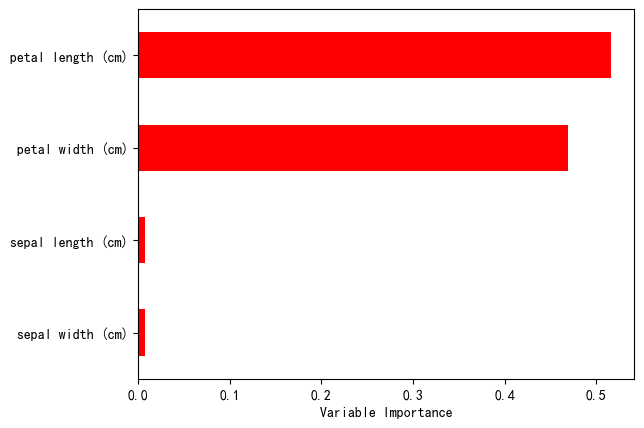

In [150]:
Importance = pd.DataFrame({'Importance':feature_importances}, index = iris.feature_names)
Importance.sort_values('Importance', axis=0, ascending=True).plot(kind='barh', color='r', )
plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.show()